In [2]:
import numpy as np                    # For numerical operations and array handling
import matplotlib.pyplot as plt        # For displaying images and plots
import imageio.v3 as iio               # For loading/saving images (preferred)
import cv2                             # OpenCV for computer vision operations
import skimage as sk
import skimage.io as skio
from skimage import io, img_as_ubyte
from skimage.transform import rescale, resize
from scipy import signal
import time


In [49]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

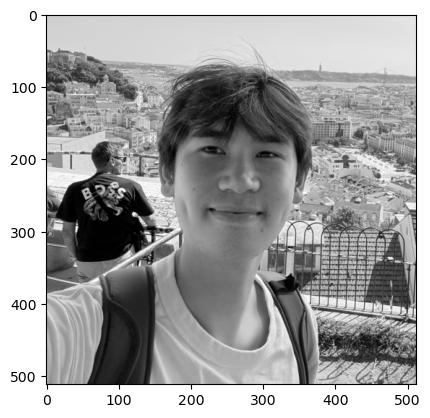

In [50]:
magnus_image = iio.imread('./data/magnust.png', mode='L') / 255
magnus_image_resized = resize(magnus_image, (512, 512), anti_aliasing=True)
plt.imshow(magnus_image_resized, cmap='gray')   

iio.imwrite('./results/magnus_bw.png', (magnus_image_resized * 255).astype(np.uint8))

In [51]:
magnus_gray = iio.imread('./results/magnus_bw.png', mode='L')



Convolution four for-loops:

Runtime: 5.527094125747681


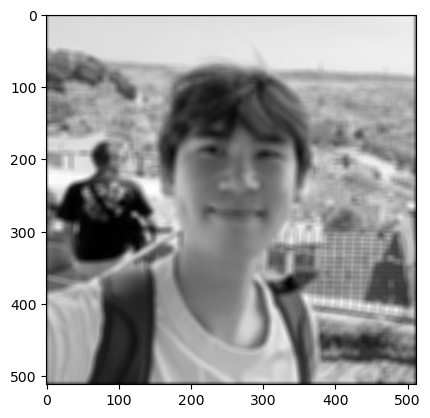

In [52]:
filter =  np.ones((9,9))

filter = filter/sum(filter)
def convolve(img, kernel):
    height_of_img, width_of_img = img.shape
    new_image = np.zeros((height_of_img, width_of_img))
    height_of_kernel, width_of_kernel = kernel.shape
    #if we can flip kernel, lets do it
    if height_of_kernel > 1:
        kernel = np.flip(kernel, axis = 0) 
    if width_of_kernel > 1: 
        kernel = np.flip(kernel, axis = 1)
    pad_x, pad_y = height_of_kernel//2, width_of_kernel//2
    #lets go through every pixel in the image
    for i in range(height_of_img):
        for j in range(width_of_img):
            running_sum = 0
            #we're centered around the pixel in our image. Now lets apply our filter 
            for row in range(-pad_x, pad_x + 1):
                for col in range(-pad_y, pad_y + 1):
                    #lets check if in bounds. If not, since 0 padding, we can assign the value to 0
                    if (0 <= row + i < height_of_img and 0 <= col + j < width_of_img): #if we're in-bounds
                        running_sum += kernel[row + pad_x, col + pad_y] * img[row+i, col+j]
            new_image[i,j] = running_sum  #update the place in the image    
    return new_image

start_time = time.time()
magnus_convolved = convolve(magnus_image_resized, filter)
end_time = time.time()
print("Runtime:", end_time - start_time)
plt.imshow(magnus_convolved, cmap='gray')


convolution 2 for-loops

0.5775859355926514


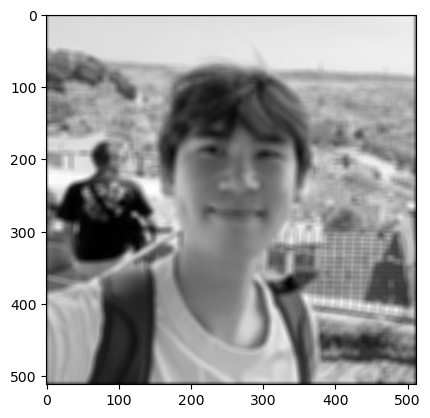

In [53]:
filter =  np.ones((9,9))

filter = filter/sum(filter)
def two_convolve(img, kernel):
    height_of_kernel, width_of_kernel = kernel.shape
    if height_of_kernel > 1:
        kernel = np.flip(kernel, axis = 0)
    if width_of_kernel > 1: 
        kernel = np.flip(kernel, axis = 1)
    pad_h, pad_w = height_of_kernel//2, width_of_kernel//2

    height_of_img, width_of_img = img.shape
    new_image = np.zeros((height_of_img, width_of_img))
    padded_img = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    for i in range(height_of_img):
        for j in range(width_of_img):
            new_image[i,j] = np.sum(padded_img[i:i+height_of_kernel, j: j+ width_of_kernel] * kernel)
            
    return new_image

start_time = time.time()
magnus_convolved = two_convolve(magnus_image_resized, filter)
end_time = time.time()
print(end_time - start_time)
magnus_norm = (magnus_convolved - np.min(magnus_convolved)) / (
    np.max(magnus_convolved) - np.min(magnus_convolved)
)
#plt.figure(figsize=magnus_gray.shape)
plt.imshow(magnus_norm, cmap='gray')
fname = './results/magnus_convolved_loop.jpg'
skio.imsave(fname, img_as_ubyte(magnus_norm))


0.036065101623535156
8.63427941498383


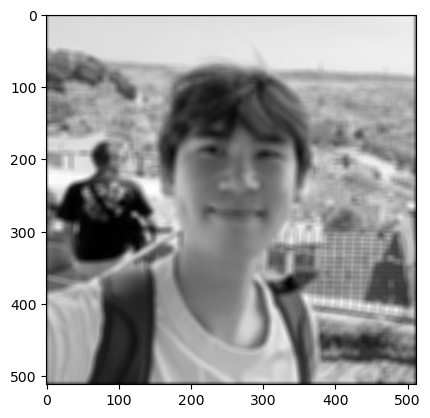

In [54]:
start_time = time.time()
new_magnus = signal.convolve2d(magnus_image_resized, filter, mode='same', boundary='fill', fillvalue=0)
end_time = time.time()
print(end_time - start_time)
plt.imshow(new_magnus, cmap='gray')

print(np.max(new_magnus))

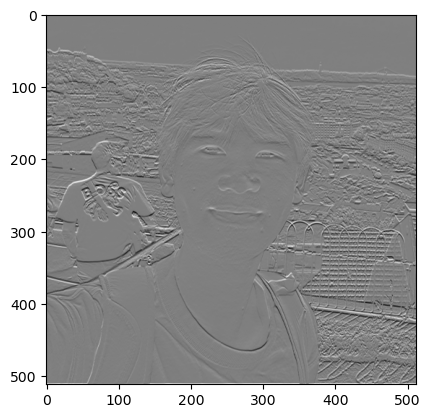

In [55]:
filter = np.array([[-1, 0, 1]])
magnus_dx = two_convolve(magnus_image_resized, filter)
plt.imshow(normalize(magnus_dx), cmap = 'gray')

normalized_magnus = normalize(magnus_dx)
fname = './results/magnus_dx.jpg'
skio.imsave(fname, img_as_ubyte(normalized_magnus))

filter_dy = np.array([[-1], [0], [1]])
magnus_dy = two_convolve(magnus_image_resized, filter_dy)
plt.imshow(normalize(magnus_dy), cmap='gray')
normalized_dy = normalize(magnus_dy)
fname = './results/magnus_dy.jpg'
skio.imsave(fname, img_as_ubyte(normalized_dy)) 

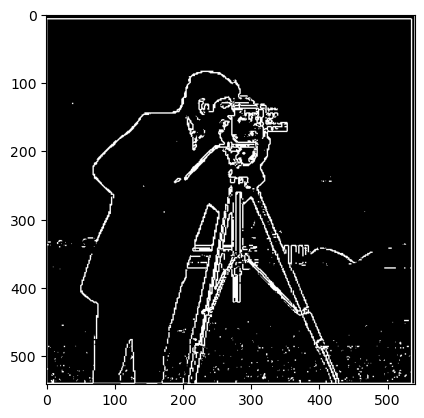

In [56]:
cameraman = iio.imread('./data/cameraman.png', mode='L')
plt.imshow(cameraman, cmap='gray')   

dx = signal.convolve2d(cameraman, np.array([[1, 0, -1]]), mode='same', boundary='fill', fillvalue=0)
#plt.imshow(dx, cmap='gray')

dy = signal.convolve2d(cameraman, np.array([[1], [0], [-1]]), mode='same', boundary='fill', fillvalue=0)
#plt.imshow(dy, cmap='gray')

fname_1 = './results/camera_dx.jpg'
fname_2 = './results/camera_dy.jpg'
skio.imsave(fname_1, img_as_ubyte(normalize(dx))) 
skio.imsave(fname_2, img_as_ubyte(normalize(dy))) 

dx_normal = normalize(np.clip(dx, 0, 1))
dy_normal = normalize(np.clip(dy,0,1))
gradient_magnitude = np.sqrt((dx ** 2) + (dy ** 2))

plt.imshow(normalize(gradient_magnitude), cmap = 'gray')

fname_3 = './results/gradient_magnitude.jpg'
skio.imsave(fname_3, img_as_ubyte(normalize(gradient_magnitude)))

normal_grad = normalize(gradient_magnitude)
threshold = 57
# Apply threshold in place
gradient_magnitude[gradient_magnitude < threshold] = 0
gradient_magnitude[gradient_magnitude >= threshold] = 1

plt.imshow(gradient_magnitude, cmap = 'gray')
fname_4 = './results/binary_mask_simple.jpg'
skio.imsave(fname_4, img_as_ubyte(gradient_magnitude))

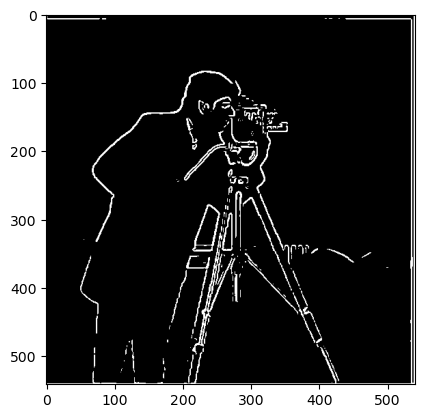

In [56]:
gaus_kernel_1d = cv2.getGaussianKernel(7, 1)
gaus_kernel_2d = gaus_kernel_1d @ gaus_kernel_1d.T
plt.imshow(gaus_kernel_2d, cmap = 'gray')

iio.imwrite("./results/gaus_kernel_2d.jpg", img_as_ubyte(gaus_kernel_2d))

gaus_kernel_2d /= gaus_kernel_2d.sum()

gaus_cameraman = signal.convolve2d(cameraman, gaus_kernel_2d, mode='same', boundary='fill', fillvalue=0)

fname = './results/gaus_cameraman.jpg'
#iio.imwrite(fname, img_as_ubyte(normalize(gaus_cameraman)))

dx_gaus = signal.convolve2d(gaus_cameraman, np.array([[1, 0, -1]]), mode='same', boundary='fill', fillvalue=0)
#plt.imshow(dx, cmap='gray')

dy_gaus = signal.convolve2d(gaus_cameraman, np.array([[1], [0], [-1]]), mode='same', boundary='fill', fillvalue=0)
#plt.imshow(dy, cmap='gray')

gradient_magnitude_gaus = np.sqrt((dx_gaus ** 2) + (dy_gaus ** 2))

threshold =57
# Apply threshold in place
gradient_magnitude_gaus[gradient_magnitude_gaus < threshold] = 0
gradient_magnitude_gaus[gradient_magnitude_gaus >= threshold] = 1

plt.imshow(gradient_magnitude_gaus, cmap = 'gray')

fname_gaus = './results/gradient_gaus_cameraman.jpg'
iio.imwrite(fname_gaus, img_as_ubyte(gradient_magnitude_gaus))



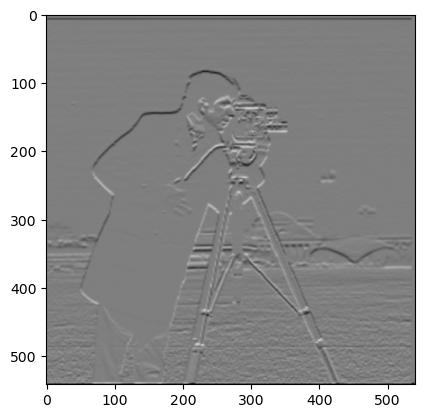

In [43]:
convolved_gaus_filter_x = signal.convolve2d(gaus_kernel_2d, np.array([[1, 0, -1]]), mode='same', boundary='fill', fillvalue=0)
#plt.imshow(dx, cmap='gray')
convolved_gaus_filter_y = signal.convolve2d(gaus_kernel_2d, np.array([[1], [0], [-1]]), mode='same', boundary='fill', fillvalue=0)

#plt.imshow(convolved_gaus_filter_x, cmap = 'gray')
plt.imshow(convolved_gaus_filter_y, cmap = 'gray')

image_x = signal.convolve2d(cameraman, convolved_gaus_filter_x, mode='same', boundary = 'fill', fillvalue=0)
image_y = signal.convolve2d(cameraman, convolved_gaus_filter_y, mode='same', boundary = 'fill', fillvalue=0)
plt.imshow(normalize(image_y), cmap='gray')


derivative = np.sqrt(image_x **2 + image_y **2)

threshold = 57
derivative[derivative < threshold] = 0
derivative[derivative >= threshold] = 1

#plt.imshow(normalize(derivative), cmap = 'gray')
#iio.imwrite('./results/dog_binary_mask.jpg', img_as_ubyte(normalize(derivative)))

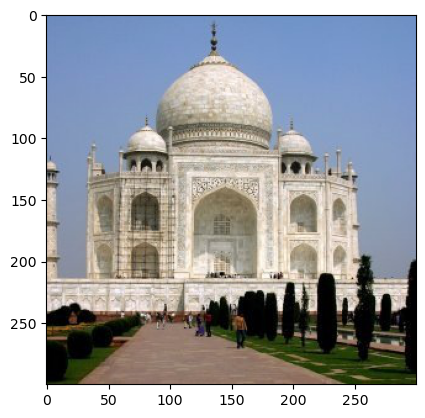

In [51]:
def sharpen(image, kernel, alpha):
    identity=signal.unit_impulse(kernel.shape)
    new_mask = (1+alpha)*identity - (alpha * kernel)
    convolved_R = signal.convolve2d(image[:,:,0], new_mask, mode='same', boundary='fill', fillvalue = 0)
        #normalized_R = convolved_R / np.max(convolved_R)

    convolved_G = signal.convolve2d(image[:,:,1], new_mask, mode='same', boundary='fill', fillvalue = 0) 
        #normalized_G = convolved_G / np.max(convolved_G)

    convolved_B = signal.convolve2d(image[:,:,2], new_mask, mode='same', boundary='fill', fillvalue = 0) 
        #normalized_B = convolved_B / np.max(convolved_B)

    full_image = np.stack([convolved_R, convolved_G, convolved_B], axis = 2)    

    clipped = np.clip(full_image, 0, 255)
    return clipped

def unsharpen(image, kernel):
    red_high = image[:, :, 0] - signal.convolve2d(image[:,:,0], kernel, mode='same', boundary = 'fill', fillvalue=0)
    blue_high = image[:, :, 1] - signal.convolve2d(image[:,:,1], kernel, mode='same', boundary = 'fill', fillvalue=0)
    green_high = image[:, :, 2] - signal.convolve2d(image[:,:,2], kernel, mode='same', boundary = 'fill', fillvalue=0)
    return np.stack([red_high, blue_high, green_high], axis = 2)

taj = iio.imread('./data/taj.jpg')
plt.imshow(taj) 
iio.imwrite("./results/taj.jpg", img_as_ubyte(taj))  


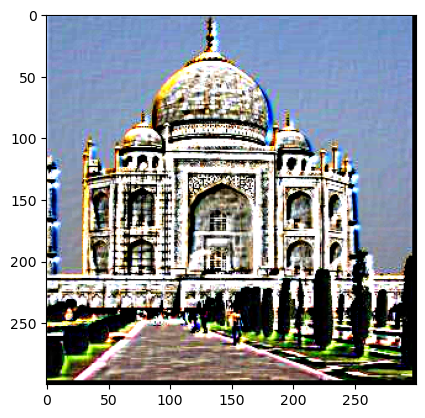

In [61]:
taj_high_freq = unsharpen(taj, gaus_kernel_2d)
sharpened_taj = sharpen(taj, gaus_kernel_2d, 5) 
#print(sharpened_taj)
#plt.imshow(normalize(sharpened_taj))   
plt.imshow(normalize(sharpened_taj))
#iio.imwrite('./results/taj_high_freq.jpg', img_as_ubyte(normalize(taj_high_freq)))  
iio.imwrite('./results/taj_sharpened_5.jpg', img_as_ubyte(normalize(sharpened_taj)))


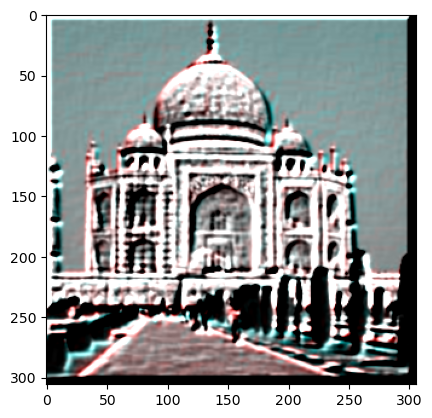

In [69]:
taj_blurred_r = signal.convolve2d(taj[:,:,0], gaus_kernel_2d, mode='full', boundary = 'fill', fillvalue=0)
taj_blurred_g = signal.convolve2d(taj[:,:,1], gaus_kernel_2d, mode='full', boundary = 'fill', fillvalue=0)
taj_blurred_b = signal.convolve2d(taj[:,:,1], gaus_kernel_2d, mode='full', boundary = 'fill', fillvalue=0)

taj_blurred = np.stack([taj_blurred_r, taj_blurred_g, taj_blurred_b], axis = 2)

plt.imshow(normalize(taj_blurred))

#iio.imwrite("./results/2-1/taj_blurred.jpg", img_as_ubyte(normalize(taj_blurred)))
taj_blurred_high = unsharpen(taj_blurred, gaus_kernel_2d)
iio.imwrite("./results/2-1/taj_blurred_high.jpg", img_as_ubyte(normalize(taj_blurred_high)))

taj_unblurred = sharpen(taj_blurred, gaus_kernel_2d, 5)
#print(taj_unblurred)
plt.imshow(normalize(taj_unblurred), cmap='gray')   
iio.imwrite("./results/2-1/taj_unblurred_5.jpg", img_as_ubyte(normalize(taj_unblurred)))

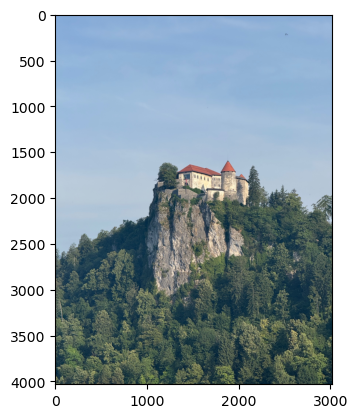

In [70]:
castle = iio.imread('./data/castle.jpeg')
plt.imshow(castle)   

iio.imwrite("./results/2-1/castle_bw.jpg", img_as_ubyte(normalize(castle)))

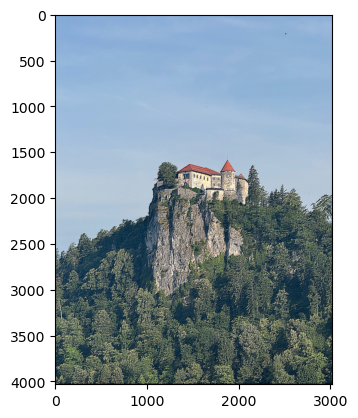

In [72]:

plt.imshow(normalize(sharpen(castle, gaus_kernel_2d, 2)))
iio.imwrite("./results/2-1/castle_sharp.jpg", img_as_ubyte(normalize(sharpen(castle, gaus_kernel_2d, 2))))

Hybrid Images

In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as sktr



def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, dscale, channel_axis=-1, anti_aliasing=True)
    else:
        im2 = sktr.rescale(im2, 1./dscale, channel_axis=-1, anti_aliasing=True)
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    print("im1 shape:", im1.shape)
    print("im2 shape:", im2.shape)
    assert im1.shape[:2] == im2.shape[:2]
    return im1, im2

def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2


if __name__ == "__main__":
    # 1. load the image
    # 2. align the two images by calling align_images
    # Now you are ready to write your own code for creating hybrid images!
    pass


In [42]:
def hybrid_image(im1, im2, sigma1, sigma2):
    gaus_kernel_1d = cv2.getGaussianKernel(6*sigma1+1, sigma1)
    gaus_kernel_2d = gaus_kernel_1d @ gaus_kernel_1d.T
    low_pass = signal.convolve2d(im1, gaus_kernel_2d, mode='same', boundary = 'fill', fillvalue=0)

    gaus_kernel_1d_high = cv2.getGaussianKernel(6*sigma2+1, sigma2)
    gaus_kernel_2d_high = gaus_kernel_1d_high @ gaus_kernel_1d_high.T
    high_pass = im2-signal.convolve2d(im2, gaus_kernel_2d_high, mode='same', boundary = 'fill', fillvalue=0)
    
    return low_pass + high_pass

def get_low_and_high(im1, im2, sigma1, sigma2):
    gaus_kernel_1d = cv2.getGaussianKernel(6*sigma1+1, sigma1)
    gaus_kernel_2d = gaus_kernel_1d @ gaus_kernel_1d.T
    low_pass = signal.convolve2d(im1, gaus_kernel_2d, mode='same', boundary = 'fill', fillvalue=0)

    gaus_kernel_1d_high = cv2.getGaussianKernel(6*sigma2+1, sigma2)
    gaus_kernel_2d_high = gaus_kernel_1d_high @ gaus_kernel_1d_high.T
    high_pass = im2-signal.convolve2d(im2, gaus_kernel_2d_high, mode='same', boundary = 'fill', fillvalue=0)
    return low_pass, high_pass


In [88]:
import matplotlib.pyplot as plt
#from align_image_code import align_images
%matplotlib qt

# First load images

# high sf
im1 = iio.imread('./data/DerekPicture.jpg')/255.
# low sf
im2 = iio.imread('./data/nutmeg.jpg')/255
# Next align images (this code is provided, but may be improved)
im2_aligned, im1_aligned = align_images(im2, im1)


Please select 2 points in each image for alignment.
im1 shape: (1310, 745, 3)
im2 shape: (1310, 745, 3)
im1 shape: (1310, 745, 3)
im2 shape: (1310, 745, 3)


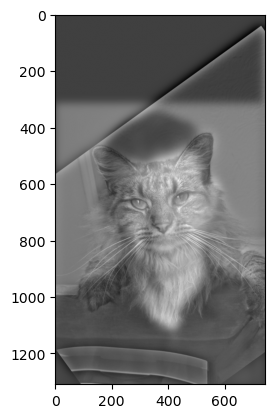

In [101]:
%matplotlib inline

## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies

sigma1 = 14
sigma2 = 18


im1_gray = 0.299*im1_aligned[:,:,0] + 0.587*im1_aligned[:,:,1] + 0.114*im1_aligned[:,:,2]
im2_gray = 0.299*im2_aligned[:,:,0] + 0.587*im2_aligned[:,:,1] + 0.114*im2_aligned[:,:,2]

# high sf
im1 = iio.imread('./data/DerekPicture.jpg', mode = 'L')/255.
# low sf
im2 = iio.imread('./data/nutmeg.jpg', mode = 'L')/255
iio.imwrite("./results/2-2/professor_gray.jpg", img_as_ubyte(im1))
iio.imwrite("./results/2-2/cat_gray.jpg", img_as_ubyte(im2))
hybrid = hybrid_image(im1_gray, im2_gray, sigma1, sigma2)

#print(hybrid)

plt.imshow(hybrid, cmap='gray')
plt.show
iio.imwrite("./results/2-2/cat_man.jpg", img_as_ubyte(normalize(hybrid)))

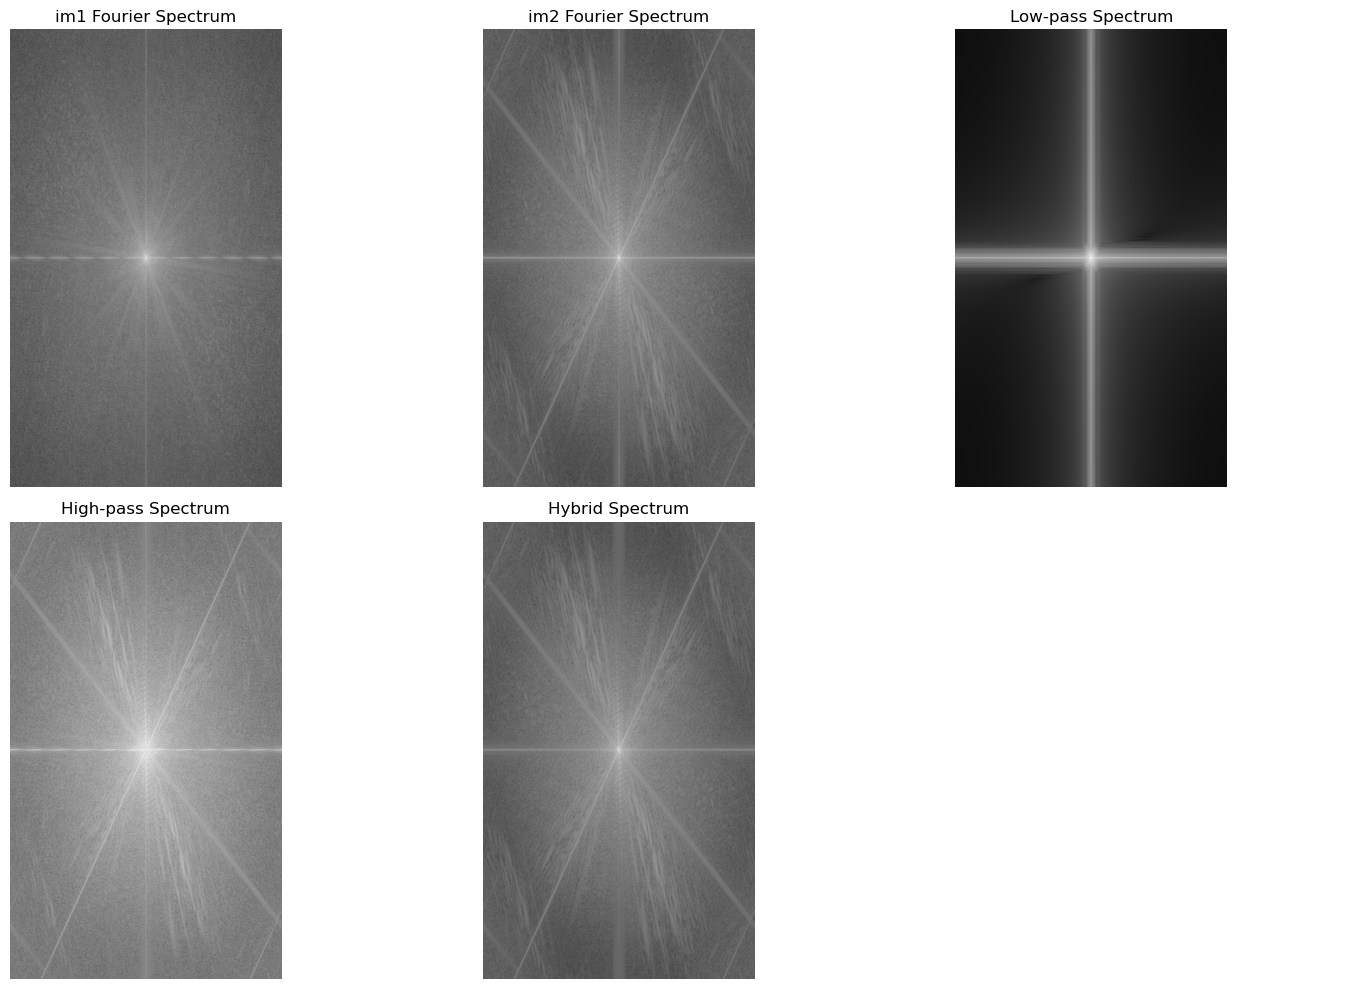

In [255]:
%matplotlib inline
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original aligned images in frequency domain
axes[0, 0].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im1_gray)))), 
                  cmap='gray', origin='lower')
axes[0, 0].set_title("im1 Fourier Spectrum")

axes[0, 1].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im2_gray)))), 
                  cmap='gray', origin='lower')
axes[0, 1].set_title("im2 Fourier Spectrum")


# Low-pass and high-pass
axes[0, 2].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid - im2_gray)))), 
                  cmap='gray', origin='lower')
axes[0, 2].set_title("Low-pass Spectrum")

axes[1, 0].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid - im1_gray)))), 
                  cmap='gray', origin='lower')
axes[1, 0].set_title("High-pass Spectrum")

# Hybrid
axes[1, 1].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))), 
                  cmap='gray', origin='lower')
axes[1, 1].set_title("Hybrid Spectrum")

# Hide unused subplot if grid is bigger than needed
axes[1, 2].axis("off")

# Make layout nicer
for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()

In [44]:
%matplotlib qt

im1 = iio.imread('./data/alignment/john_cena.jpg')/255.
# low sf
im2 = iio.imread('./data/alignment/the_rock.jpg')/255
# Next align images (this code is provided, but may be improved)
im2_aligned, im1_aligned = align_images(im2, im1)

Please select 2 points in each image for alignment.
im1 shape: (669, 369, 3)
im2 shape: (669, 369, 3)
im1 shape: (669, 369, 3)
im2 shape: (669, 369, 3)


(480, 360)


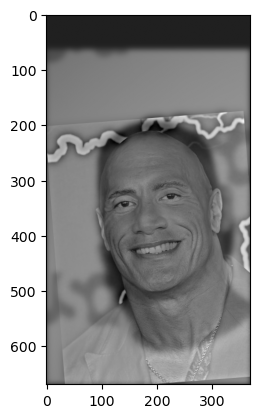

In [50]:
%matplotlib inline

## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies

sigma1 = 5
sigma2 = 7


john_gray = 0.299*im1_aligned[:,:,0] + 0.587*im1_aligned[:,:,1] + 0.114*im1_aligned[:,:,2]
rock_gray = 0.299*im2_aligned[:,:,0] + 0.587*im2_aligned[:,:,1] + 0.114*im2_aligned[:,:,2]

# high sf
im1 = iio.imread('./data/alignment/the_rock.jpg', mode = 'L')/255.

print(im1.shape)
# low sf
im2 = iio.imread('./data/alignment/john_cena.jpg', mode = 'L')/255

iio.imwrite("./results/2-2/rock_gray.jpg", img_as_ubyte(im1))
iio.imwrite("./results/2-2/john_gray.jpg", img_as_ubyte(im2))

iio.imwrite("./results/2-2/rock_aligned.jpg", img_as_ubyte(rock_gray))
iio.imwrite("./results/2-2/john_aligned.jpg", img_as_ubyte(john_gray))


hybrid = hybrid_image(john_gray, rock_gray, sigma1, sigma2)

#print(hybrid)

plt.imshow(hybrid, cmap='gray')
plt.show
iio.imwrite("./results/2-2/john_rock.jpg", img_as_ubyte(normalize(hybrid)))

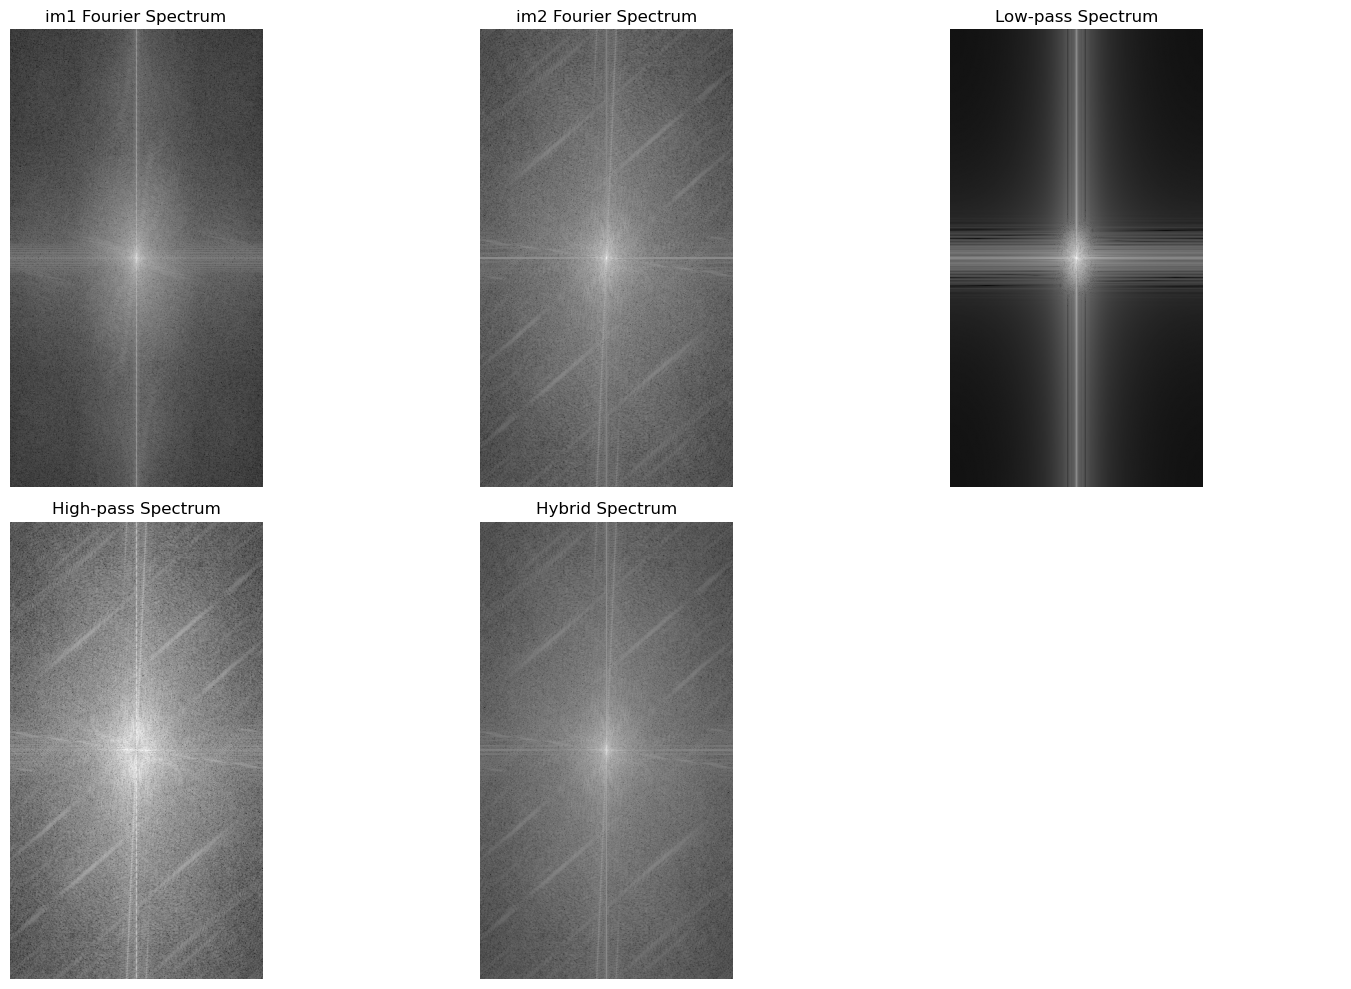

In [49]:
%matplotlib inline
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original aligned images in frequency domain
axes[0, 0].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(john_gray)))), 
                  cmap='gray', origin='lower')
axes[0, 0].set_title("im1 Fourier Spectrum")

iio.imwrite("./results/2-2/fourier/john_aligned_fourier.jpg", img_as_ubyte(normalize(np.log(np.abs(np.fft.fftshift(np.fft.fft2(john_gray)))))))

axes[0, 1].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(rock_gray)))), 
                  cmap='gray', origin='lower')
axes[0, 1].set_title("im2 Fourier Spectrum")

iio.imwrite("./results/2-2/fourier/rock_aligned_fourier.jpg", img_as_ubyte(normalize(np.log(np.abs(np.fft.fftshift(np.fft.fft2(rock_gray)))))))


# Low-pass and high-pass
axes[0, 2].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid - rock_gray)))), 
                  cmap='gray', origin='lower')
axes[0, 2].set_title("Low-pass Spectrum")

iio.imwrite("./results/2-2/fourier/low_spectrum.jpg", img_as_ubyte(normalize(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid - rock_gray)))))))

axes[1, 0].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid - john_gray)))), 
                  cmap='gray', origin='lower')
axes[1, 0].set_title("High-pass Spectrum")

iio.imwrite("./results/2-2/fourier/high_spectrum.jpg", img_as_ubyte(normalize(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid - john_gray)))))))
# Hybrid
axes[1, 1].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))), 
                  cmap='gray', origin='lower')
axes[1, 1].set_title("Hybrid Spectrum")

iio.imwrite("./results/2-2/fourier/hybrid_spectrum.jpg", img_as_ubyte(normalize(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))))))

# Hide unused subplot if grid is bigger than needed
axes[1, 2].axis("off")

# Make layout nicer
for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()

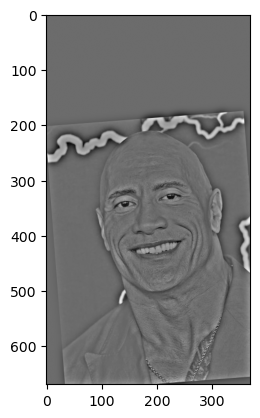

In [53]:
john_low, rock_high = get_low_and_high(john_gray, rock_gray, sigma1, sigma2)

plt.imshow(normalize(john_low), cmap = 'gray')
plt.imshow(normalize(rock_high), cmap = 'gray')

In [71]:
%matplotlib qt

im1 = iio.imread('./data/alignment/great_wave.jpg')/255.
# low sf
im2 = iio.imread('./data/alignment/ocean-wave.jpg')/255
# Next align images (this code is provided, but may be improved)
im2_aligned, im1_aligned = align_images(im2, im1)

Please select 2 points in each image for alignment.
im1 shape: (699, 1185, 3)
im2 shape: (699, 1185, 3)
im1 shape: (699, 1185, 3)
im2 shape: (699, 1185, 3)


(675, 1000)


<function matplotlib.pyplot.show(close=None, block=None)>

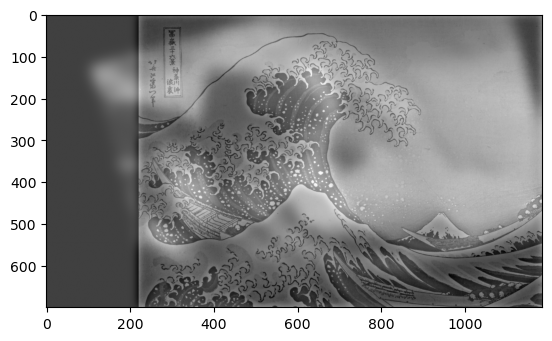

In [78]:
%matplotlib inline

## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies

sigma1 = 15
sigma2 = 10


im1_gray = 0.299*im1_aligned[:,:,0] + 0.587*im1_aligned[:,:,1] + 0.114*im1_aligned[:,:,2]
im2_gray = 0.299*im2_aligned[:,:,0] + 0.587*im2_aligned[:,:,1] + 0.114*im2_aligned[:,:,2]

# high sf
im1 = iio.imread('./data/alignment/ocean-wave.jpg', mode = 'L')/255.

print(im1.shape)
# low sf
im2 = iio.imread('./data/alignment/great_wave.jpg', mode = 'L')/255

iio.imwrite("./results/2-2/ocean_gray.jpg", img_as_ubyte(im1))
iio.imwrite("./results/2-2/great_wave_gray.jpg", img_as_ubyte(im2))
hybrid = hybrid_image(im2_gray, im1_gray, sigma1, sigma2)

#print(hybrid)

plt.imshow(hybrid, cmap='gray')
plt.show
#iio.imwrite("./results/2-2/john_rock.jpg", img_as_ubyte(normalize(hybrid)))

In [77]:
iio.imwrite("./results/2-2/wave_1.jpg", img_as_ubyte(normalize(hybrid)))

Lets tackle frequency

In [ ]:
def gaussian_stack_bw(img, levels, sigma):
    stack = [img.copy()]

    for i in range(0, levels):
        get_prev = stack[i]
        gaus_kernel = cv2.getGaussianKernel(6*sigma+1, sigma)
        gaus_kernel_2d = gaus_kernel @ gaus_kernel.T
        convolved_R = signal.convolve2d(get_prev, gaus_kernel_2d, mode='same', boundary='symmetric') 
        #norm_R = (convolved_R - np.min(convolved_R)) / (np.max(convolved_R) - np.min(convolved_R) + 1e-8)
        #np.clip(convolved_R, 0, 1)
        stack.append(convolved_R)

    return stack
    

def laplacian_stack_bw(img, levels, sigma):
    gaus_stack = gaussian_stack_bw(img, levels, sigma)
    stack = []
    for i in range(1, len(gaus_stack)):
        high_freq = gaus_stack[i-1] - gaus_stack[i]
        #scaled = (high_freq - np.min(high_freq))/ (np.max(high_freq) - np.min(high_freq)) #scale back to 0 and 1
        scaled = high_freq
        stack.append(scaled)
    stack.append(gaus_stack[-1])
    return stack
    #create it using gaussian stack

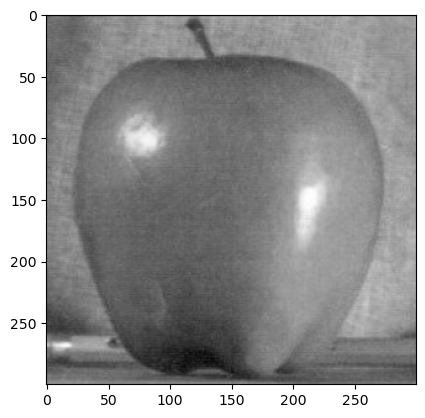

In [62]:
apple = iio.imread("./data/apple.jpeg", mode='L') / 255
plt.imshow(apple, cmap='gray')
gaus_stack_apple = gaussian_stack_bw(apple, 5, 1)


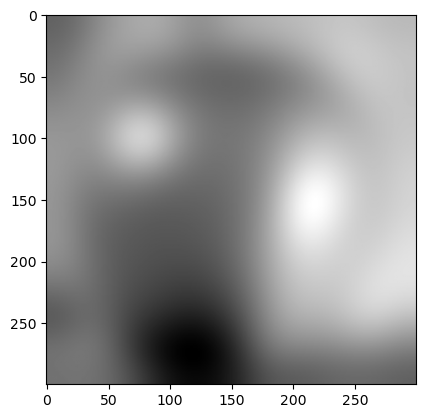

In [63]:

plt.imshow(gaus_stack_apple[5], cmap='gray')

In [64]:
orange = iio.imread("./data/orange.jpeg", mode='L')/255
#orange_gaus = gaussian_stack(orange, 5, 1)
orange_lap = laplacian_stack_bw(orange, 5, 1)
apple_lap = laplacian_stack_bw(apple, 5, 1)

#apple_lap = laplacian_stack_bw(apple, 5, 1)

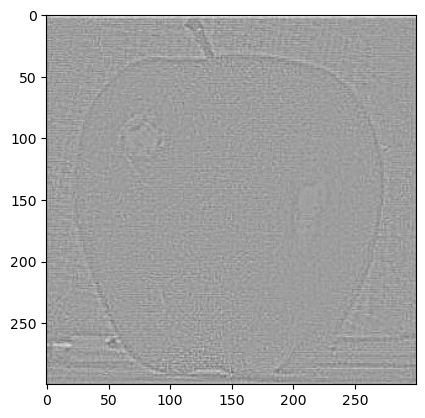

In [65]:
plt.imshow(orange_lap[0], cmap='gray')
plt.imshow(apple_lap[0], cmap='gray')

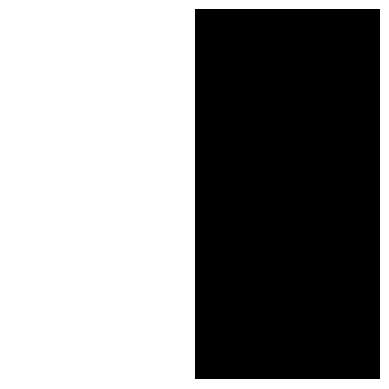

In [11]:
height, width = 300, 300
mask = np.zeros((height, width))  # start with all black

# make the right half white
mask[:, :width//2] = 1

iio.imwrite('./results/2-3/mask_original.jpg', img_as_ubyte(mask))
# Convert to 3 channels
#mask_rgb = np.stack([mask, mask, mask], axis=2)

plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

#gaussian_mask = gaussian_stack_bw(mask, 5, 3)

#print(mask_rgb.shape)  # Should be (300, 300, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.00000000000028].


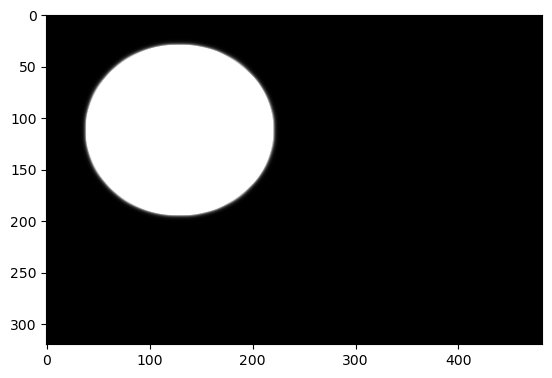

In [67]:
plt.imshow(gaussian_mask[5], cmap='gray')


In [68]:
#combined = create_combined_image_bw(apple, orange, mask, 5, 10)
#plt.imshow(orange_lap[0] * mask + apple_lap[0] * (1-mask), cmap='gray')
#new_image = smash_together(combined)


In [ ]:
new_image = np.zeros((300, 300))
gaussian_mask = gaussian_stack_bw(mask, 5, 10)
#more_new_apple_lap = laplacian_stack_bw(apple, 5, 10)
#for i in range(0,1):
#    new_image += apple_lap[i] * gaussian_mask[i] + orange_lap[i] * (1-gaussian_mask[i])
#for i in range(0, len(apple_lap)):
#    new_image += apple_lap[i]
new_image += apple_lap[5] + apple_lap[4] + apple_lap[3] + apple_lap[2] + apple_lap[1] + apple_lap[0]


plt.imshow(new_image, cmap='gray')

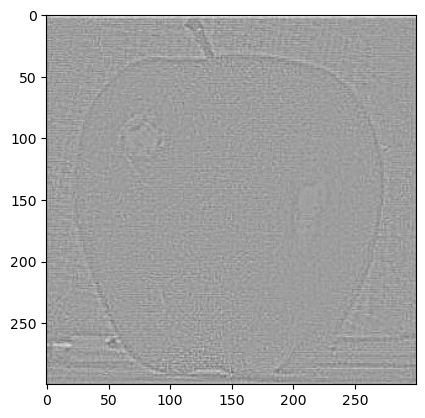

In [27]:
apple_lap = 0
apple_lap = laplacian_stack_bw(apple, 5, 1)
plt.imshow(apple_lap[0], cmap='gray')

In [28]:
def create_combined_image_bw(im1, im2, mask, levels, sigma1, sigma2, sigma_mask):
    #create laplacians
    im1_lap = laplacian_stack_bw(im1, levels, sigma1)
    im2_lap = laplacian_stack_bw(im2, levels, sigma2)
    #create gaussian mask
    mask_blur = gaussian_stack_bw(mask, levels, sigma_mask)

    saved_convolutions = []

    for i in range(0, len(im1_lap)):
        #compute our convolution for the ith layer, across 3 channels
        new_image = im1_lap[i]* mask_blur[i] + im2_lap[i] *(1 - mask_blur[i])
        #append to list
        saved_convolutions.append(new_image)

    return np.stack(saved_convolutions, axis = 0)




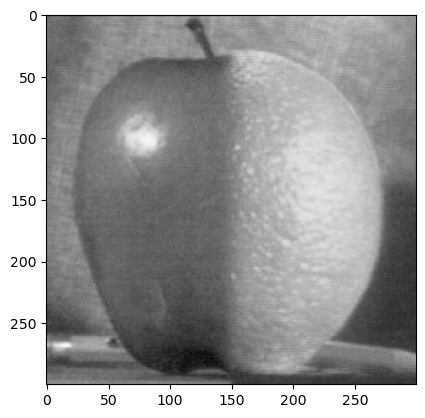

In [29]:
combined = create_combined_image_bw(apple, orange, mask, 5, 3, 3, 3)
#plt.imshow(combined[0], cmap='gray')

total = np.sum(combined, axis=0)
plt.imshow(total, cmap='gray')

Lets try it in color now

In [ ]:
def gaussian_stack_rgb(img, levels, sigma):
    stack = [img.copy()]
    #gaus_kernel = cv2.getGaussianKernel(6*sigma+1, sigma)
    #gaus_kernel_2d = gaus_kernel @ gaus_kernel.T
    #gaus_kernel_2d /= np.sum(gaus_kernel_2d)
    for i in range(0, levels):
        get_prev = stack[i]
        sigma_i = sigma #* (2 ** i)
        gaus_kernel = cv2.getGaussianKernel(6*sigma_i+1, sigma_i)
        gaus_kernel_2d = gaus_kernel @ gaus_kernel.T
        convolved_R = signal.convolve2d(get_prev[:,:,0], gaus_kernel_2d, mode='same', boundary='symmetric')
        #normalized_R = convolved_R / np.max(convolved_R)

        convolved_G = signal.convolve2d(get_prev[:,:,1], gaus_kernel_2d, mode='same', boundary='symmetric') 
        #normalized_G = convolved_G / np.max(convolved_G)

        convolved_B = signal.convolve2d(get_prev[:,:,2], gaus_kernel_2d, mode='same', boundary='symmetric') 
        #normalized_B = convolved_B / np.max(convolved_B)

        full_image = np.stack([convolved_R, convolved_G, convolved_B], axis = 2)
        stack.append(full_image)

    return stack
    

def laplacian_stack_rgb(img, levels, sigma):
    gaus_stack = gaussian_stack_rgb(img, levels, sigma)
    stack = []
    for i in range(1, len(gaus_stack)):
        high_freq = gaus_stack[i-1] - gaus_stack[i]
        #scaled = (high_freq - np.min(high_freq))/ (np.max(high_freq) - np.min(high_freq)) #scale back to 0 and 1
        scaled = high_freq
        stack.append(scaled)
    stack.append(gaus_stack[-1])
    return stack
    #create it using gaussian stack

In [58]:
apple_color = iio.imread("./data/apple.jpeg") / 255
color_apple_lap = laplacian_stack_rgb(apple_color, 5, 2)

#plt.imshow(((color_apple_lap[0] - np.min(color_apple_lap[0]))/(np.max(color_apple_lap[0])-np.min(color_apple_lap[0]))))

orange_color = iio.imread("./data/orange.jpeg") / 255

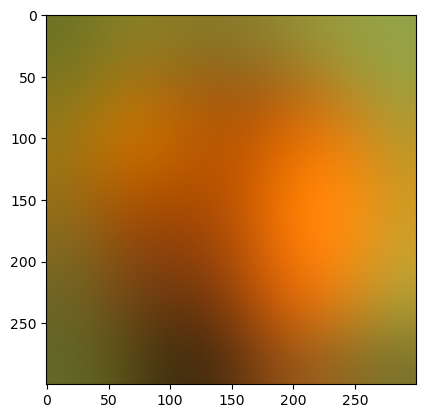

In [59]:
plt.imshow(normalize(color_apple_lap[5]))

In [60]:
def combined_color(im1, im2, mask, levels, sigma1, sigma2, sigma3):
    #create gaussians
    im1_lap = laplacian_stack_rgb(im1, levels, sigma1)
    im2_lap = laplacian_stack_rgb(im2, levels, sigma2)
    #create blurred mask
    mask_blur = gaussian_stack_rgb(mask, levels, sigma3)
    #convolve 
    saved_convolutions = []

    for i in range(len(im1_lap)):
        #compute our convolution for the ith layer, across 3 channels

        #compute our convolution for the ith layer, across 3 channels
        new_image = im1_lap[i]* mask_blur[i] + im2_lap[i] *(1 - mask_blur[i])
        #append to list

        saved_convolutions.append(new_image)
        
        #append to list

    return saved_convolutions




In [61]:
mask_rgb = np.stack([mask, mask, mask], axis=-1)

combined_example = combined_color(apple_color, orange_color, mask_rgb, 5, 2, 2, 2)


KeyboardInterrupt: 

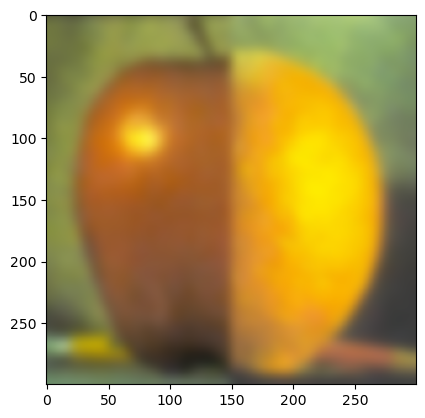

In [13]:
plt.imshow(normalize(combined_example[5]))

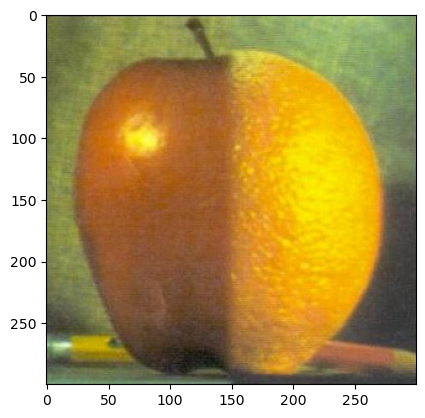

In [14]:
empty_image = np.sum(combined_example, axis =0)
rescaled = (empty_image - np.min(empty_image)) / (np.max(empty_image)- np.min(empty_image))

plt.imshow(rescaled)

Lets try a better mask!

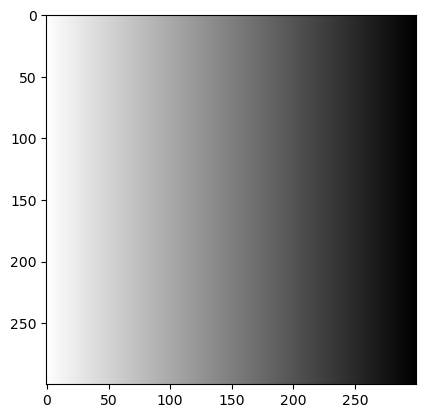

In [22]:
height, width = 300, 300
new_mask = np.tile(np.linspace(1, 0, width), (height, 1))
plt.imshow(new_mask, cmap='gray')

In [ ]:
#new_mask_3 = np.stack([new_mask, new_mask, new_mask], axis=-1)

#new_combined_example = combined_color(apple_color, orange_color, new_mask_3, 5, 2, 2, 2)

#empty_image = np.sum(new_combined_example, axis =0)
#rescaled = (empty_image - np.min(empty_image)) / (np.max(empty_image)- np.min(empty_image))

#plt.imshow(rescaled)

NameError: name 'new_mask' is not defined

In [10]:
apple_lap = laplacian_stack_rgb(apple_color, 5, 2) #apple
apple_gas = gaussian_stack_rgb(apple_color, 5, 2) #apple

orange_lap = laplacian_stack_rgb(orange_color, 5, 2) #orange
orange_gas = gaussian_stack_rgb(orange_color, 5, 2) #orange

mask_gas = gaussian_stack_rgb(mask_rgb, 5, 2) #mask




Export time!


In [11]:
for i, image in enumerate(apple_lap):
    iio.imwrite(f"./results/2-3/apple_lap/apple_lap_{i}.jpg", img_as_ubyte(normalize(image)))


In [12]:
for i, image in enumerate(apple_gas):
    iio.imwrite(f"./results/2-3/apple_gas/apple_gas_{i}.jpg", img_as_ubyte(normalize(image)))


In [13]:
for i, image in enumerate(orange_lap):
    iio.imwrite(f"./results/2-3/orange_lap/orange_lap_{i}.jpg", img_as_ubyte(normalize(image)))


In [14]:
for i, image in enumerate(orange_gas):
    iio.imwrite(f"./results/2-3/orange_gas/orange_gas_{i}.jpg", img_as_ubyte(normalize(image)))


In [15]:
for i, image in enumerate(mask_gas):
    iio.imwrite(f"./results/2-3/mask_gas/mask_gas_{i}.jpg", img_as_ubyte(normalize(image)))


In [62]:
def combined_color_export(im1, im2, mask, levels, sigma1, sigma2, sigma3):
    #create gaussians
    im1_lap = laplacian_stack_rgb(im1, levels, sigma1)
    im2_lap = laplacian_stack_rgb(im2, levels, sigma2)
    #create blurred mask
    mask_blur = gaussian_stack_rgb(mask, levels, sigma3)
    #convolve 
    saved_convolutions = []

    for i in range(len(im1_lap)):
        #compute our convolution for the ith layer, across 3 channels

        #compute our convolution for the ith layer, across 3 channels
        im1_multiply = im1_lap[i]* mask_blur[i]
        im2_multiply = im2_lap[i] *(1 - mask_blur[i])
        combined = im1_multiply + im2_multiply
        #append to list

        saved_convolutions.append([im1_multiply, im2_multiply, combined])
        
        #append to list

    return saved_convolutions

In [63]:
get_total = combined_color_export(apple_color, orange_color, mask_rgb, 5, 2, 2, 2)

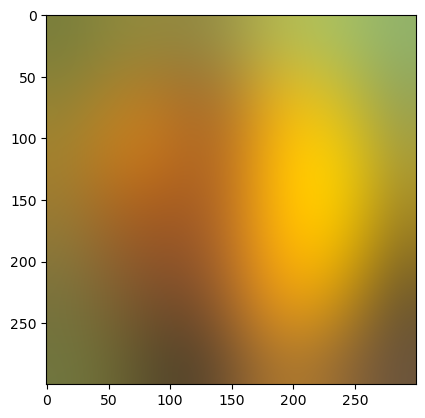

In [64]:
plt.imshow(normalize(get_total[5][2]))

In [65]:
#level 0
iio.imwrite("./results/2-3/apple_left/apple_lap_0_mask.jpg", img_as_ubyte(normalize(get_total[0][0])))
iio.imwrite("./results/2-3/orange_right/orange_lap_0_mask.jpg", img_as_ubyte(normalize(get_total[0][1])))
iio.imwrite("./results/2-3/combined/combined_0_mask.jpg", img_as_ubyte(normalize(get_total[0][2])))
#level 2
iio.imwrite("./results/2-3/apple_left/apple_lap_2_mask.jpg", img_as_ubyte(normalize(get_total[2][0])))
iio.imwrite("./results/2-3/orange_right/orange_lap_2_mask.jpg", img_as_ubyte(normalize(get_total[2][1])))
iio.imwrite("./results/2-3/combined/combined_2_mask.jpg", img_as_ubyte(normalize(get_total[2][2])))
#level 5
iio.imwrite("./results/2-3/apple_left/apple_lap_4_mask.jpg", img_as_ubyte(normalize(get_total[4][0])))
iio.imwrite("./results/2-3/orange_right/orange_lap_4_mask.jpg", img_as_ubyte(normalize(get_total[4][1])))
iio.imwrite("./results/2-3/combined/combined_4_mask.jpg", img_as_ubyte(normalize(get_total[4][2])))


In [21]:
total = np.sum(get_total, axis=0)


In [28]:
iio.imwrite("./results/2-3/final_apple_left.jpg", img_as_ubyte(normalize(total[0])))
iio.imwrite("./results/2-3/final_orange_right.jpg", img_as_ubyte(normalize(total[1])))
iio.imwrite("./results/2-3/final_result.jpg", img_as_ubyte(normalize(total[2])))

Lets do my own!

(500, 625, 3)
(500, 625, 3)
(500, 625, 3)


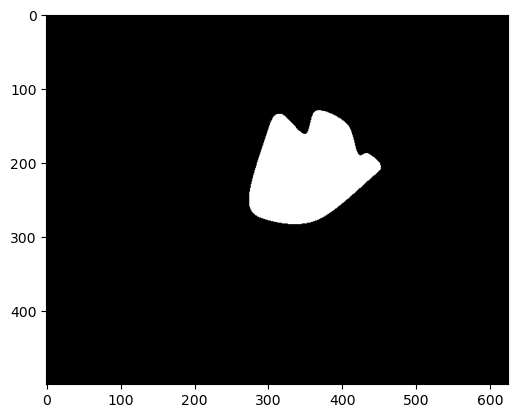

In [45]:
sailboat = iio.imread("./data/morphing/sailboat_new.png")[:,:,:3]
sand_dunes = iio.imread("./data/morphing/sand_dunes.jpg")
circle_mask = iio.imread("./data/morphing/mask_better_hopefully.png")[:,:,:3]

#print(sailboat.shape)
#print(sand_dunes.shape)
#print(circle_mask.shape)

sailboat_down = resize(sailboat, 
                         (sailboat.shape[0]//2, sailboat.shape[1]//2), 
                         anti_aliasing=True)
sand_down = resize(sand_dunes, 
                         (sailboat.shape[0]//2, sailboat.shape[1]//2), 
                         anti_aliasing=True)
circle_down = resize(circle_mask, 
                         (sailboat.shape[0]//2, sailboat.shape[1]//2), 
                         anti_aliasing=True)


plt.imshow(circle_down)


print(sailboat_down.shape)
print(sand_down.shape)
print(circle_down.shape)
#combined_sand_dune = combined_color(sailboat_down, sand_down, circle_mask, 5, 2, 2, 2)

#complete_image = np.sum(combined_sand_dune, axis =0)
#plt.imshow(normalize(complete_image))

In [46]:
combined_sand_dune = combined_color(sailboat_down, sand_down, circle_down, 5, 2, 2, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07878752515254667..1.2237386711852114].


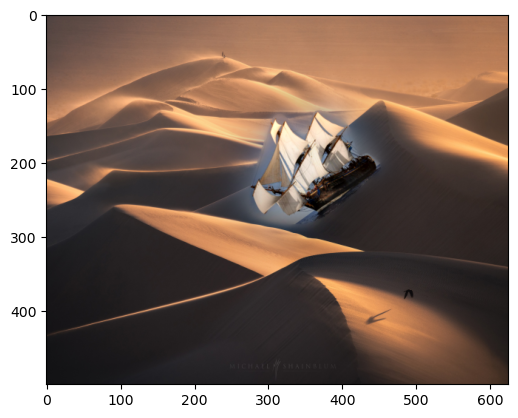

In [47]:
plt.imshow(np.sum(combined_sand_dune, axis =0))

In [48]:
iio.imwrite("./results/2-3/personal/boat_final.jpg", img_as_ubyte(normalize(np.sum(combined_sand_dune, axis =0))))
iio.imwrite("./results/2-3/personal/boat_down.jpg", img_as_ubyte(normalize(sailboat_down)))
iio.imwrite("./results/2-3/personal/sand_down.jpg", img_as_ubyte(normalize(sand_down)))
iio.imwrite("./results/2-3/personal/mask_down.jpg", img_as_ubyte(normalize(circle_down)))

In [ ]:
iio.imwrite("./")

(600, 1024, 3)
(683, 1024, 3)


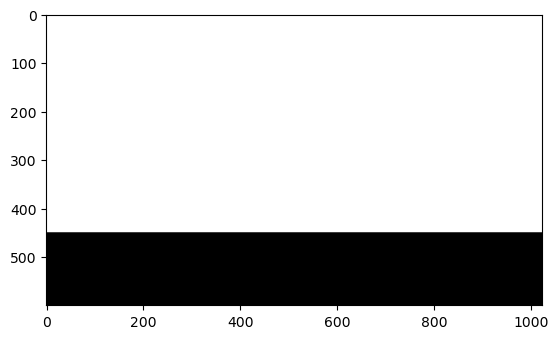

In [15]:
dragon = iio.imread("./data/morphing/dragon_fireball.jpg")
orchard = iio.imread("./data/morphing/orchard.jpg")

print(dragon.shape)
print(orchard.shape)
orchard = orchard[:600, :, :]

#dragon = resize(dragon, (dragon.shape[0]//2, dragon.shape[1]//2),  anti_aliasing=True)

#orchard = resize(orchard,(orchard.shape[0]//2, orchard.shape[1]//2),anti_aliasing=True)
plt.imshow(orchard)

height = dragon.shape[0]
width = dragon.shape[1]
mask = np.ones((height, width))  # start with all black

# make the right half white
mask[(height * 3)//4:, :] = 0
mask = np.stack([mask, mask, mask], axis=-1)

plt.imshow(mask, cmap = 'gray')

iio.imwrite("./results/2-3/personal/dragon_mask.jpg", img_as_ubyte(mask))

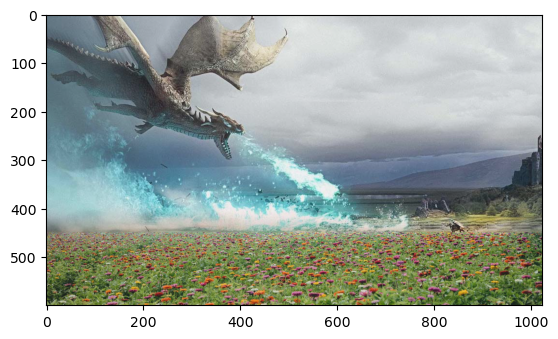

In [13]:
combined_dragon = combined_color(dragon, orchard, mask, 5, 2, 2, 2)

complete_image = np.sum(combined_dragon, axis =0)
plt.imshow(normalize(complete_image))

In [14]:
iio.imwrite("./results/2-3/personal/dragon_big.jpg", img_as_ubyte(normalize(dragon)))
iio.imwrite("./results/2-3/personal/orchard_big.jpg", img_as_ubyte(normalize(orchard)))
iio.imwrite("./results/2-3/personal/combined_big.jpg", img_as_ubyte(normalize(complete_image)))